# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
geo_ds = pd.read_excel('geo.xlsx')
print(geo_ds.shape)
geo_ds.head()

(108806, 3)


,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [3]:
geo_comment_ds = pd.read_excel('geo_comment.xlsx')
print(geo_comment_ds.shape)
geo_comment_ds.head()

(70382, 5)


,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


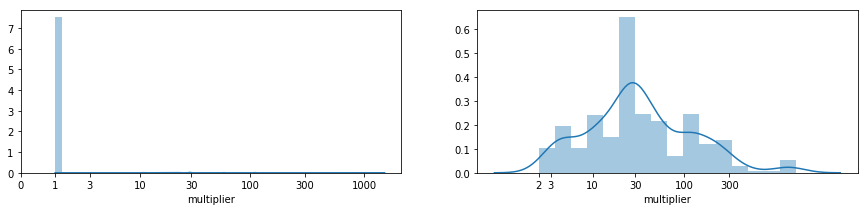

In [4]:
plt.figure(figsize=(15,3))
plt.subplot(121)
sns.distplot(np.log1p(geo_comment_ds['multiplier']))
xticks = [0,1,3,10,30,100,300,1000]
plt.xticks(np.log1p(xticks), xticks)

plt.subplot(122)
sns.distplot(np.log1p(geo_comment_ds['multiplier'][geo_comment_ds['multiplier']>1]))
xticks = [2,3,10,30,100,300]
plt.xticks(np.log1p(xticks), xticks)

plt.show()

Многие комментарии относятся к 30 людям. Это должно быть как-то связано с форматом проведения публичных слушаний.

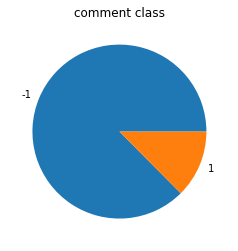

In [5]:
s = geo_ds['comment_class'].value_counts()
plt.pie(s.values, labels=s.index)
plt.title('comment class')
plt.show()

In [6]:
xlim = (geo_ds['x'].min()-0.05, geo_ds['x'].max()+0.05)
ylim = (geo_ds['y'].min()-0.05, geo_ds['y'].max()+0.05)

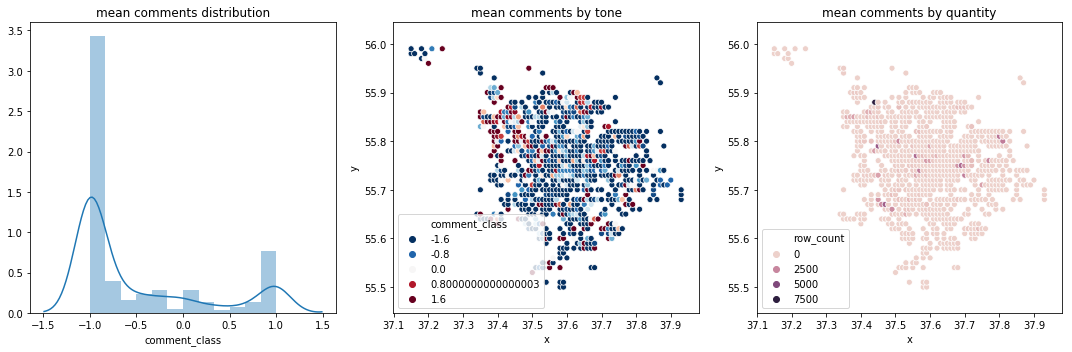

In [7]:
cds = geo_ds.copy()
cds[['x','y']] = cds[['x','y']].round(2)
cds['row_count'] = 1
cds = cds.groupby(['x','y']).agg({'comment_class':'mean', 'row_count':'sum'}).reset_index()
cds['comment_class'] = cds['comment_class'].round(1)


plt.figure(figsize=(15,5))
plt.subplot(131)
sns.distplot(cds['comment_class'])
plt.title('mean comments distribution')

plt.subplot(132)
sns.scatterplot(x='x', y='y', data=cds, hue='comment_class', palette='RdBu_r', legend='brief')
plt.title('mean comments by tone')
plt.xlim(xlim);plt.ylim(ylim)

plt.subplot(133)
sns.scatterplot(x='x', y='y', data=cds, hue='row_count', legend='brief')
plt.title('mean comments by quantity')
plt.xlim(xlim);plt.ylim(ylim)

plt.tight_layout()
plt.show()

Если округлить GPS координаты до двух точек после запятой (условно "микрорайны"), большинство отзывов все равно останутся или строго отрицательными или строго положительными.

БОльшая часть данных - это Москва. Небольшое скопление в верхнем левом углу - Зеленоград

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
for f in ['x','y','comment_class']:
    geo_ds[f+'_scal'] = StandardScaler().fit_transform(geo_ds[[f]])

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [10]:
geo_ds['comment_class'] = geo_ds['comment_class'].astype(int)

## Обязательное задание

### 1) визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)

In [11]:
from sklearn.cluster import KMeans

In [12]:
model = KMeans(n_clusters=8)
geo_ds['cluster'] = model.fit_predict(geo_ds[['x_scal','y_scal']])

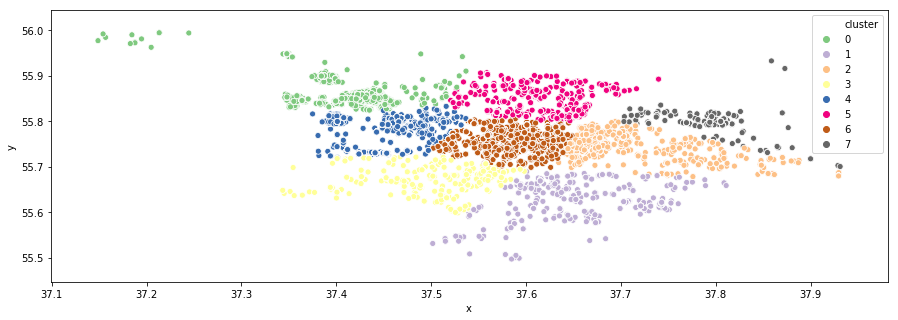

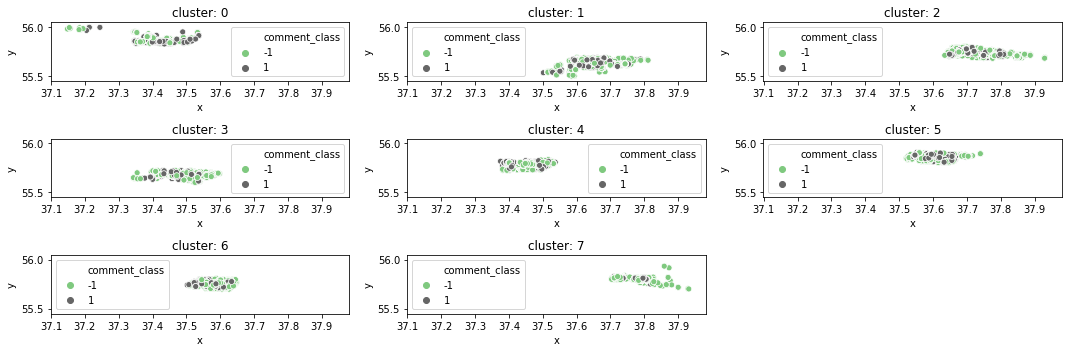

In [13]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='x', y='y', hue='cluster', data=geo_ds, palette='Accent', legend='full')
plt.xlim(xlim);plt.ylim(ylim)
plt.show()

plt.figure(figsize=(15,5))
n_cluster = geo_ds['cluster'].nunique()
for idx,v in enumerate(range(n_cluster)):
    plt.subplot(n_cluster//3+1, 3, idx+1)
    sns.scatterplot(x='x', y='y', data=geo_ds[geo_ds['cluster']==v],
                    hue='comment_class', palette='Accent', legend='full')
    plt.title(f'cluster: {v}')
    plt.xlim(xlim);plt.ylim(ylim)
plt.tight_layout()
    
plt.show()

KMeans делит данные на районы примерно равной площади. У разбиения нет какой-либо особо интересной структуры

### 2) аналогично исследовать скопления голосов за и против отдельно

In [14]:
model_com = KMeans(n_clusters=2)
geo_ds['cluster'] = model_com.fit_predict(geo_ds[['x_scal','y_scal','comment_class_scal']])

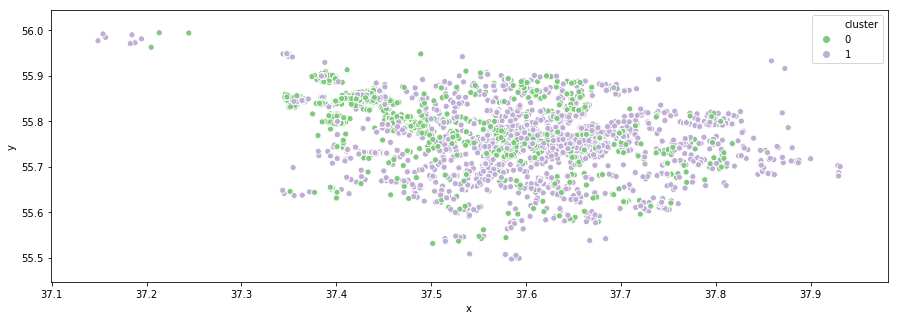

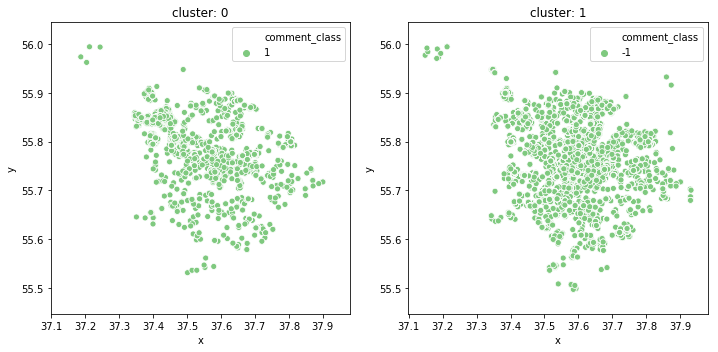

In [15]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='x', y='y', hue='cluster', data=geo_ds, palette='Accent', legend='full')
plt.xlim(xlim);plt.ylim(ylim)
plt.show()

plt.figure(figsize=(15,5))
n_cluster = geo_ds['cluster'].nunique()
for idx,v in enumerate(range(n_cluster)):
    plt.subplot(n_cluster//3+1, 3, idx+1)
    sns.scatterplot(x='x', y='y', data=geo_ds[geo_ds['cluster']==v],
                    hue='comment_class', palette='Accent', legend='full')
    plt.title(f'cluster: {v}')
    plt.xlim(xlim);plt.ylim(ylim)
plt.tight_layout()
    
plt.show()

Кластеры поделились точно по тонам комментариев

In [16]:
geo_ds_neg = geo_ds[geo_ds['comment_class']==-1]
geo_ds_pos = geo_ds[geo_ds['comment_class']==1]

model_com_neg = KMeans(n_clusters=5)
geo_ds_neg['cluster_com'] = model_com_neg.fit_predict(geo_ds_neg[['x_scal','y_scal']])
geo_ds_neg['cluster_com'] = 'neg_'+geo_ds_neg['cluster_com'].astype(str)

model_com_pos = KMeans(n_clusters=5)
geo_ds_pos['cluster_com'] = model_com_pos.fit_predict(geo_ds_pos[['x_scal','y_scal']])
geo_ds_pos['cluster_com'] = 'pos_'+geo_ds_pos['cluster_com'].astype(str)


geo_ds = pd.concat([geo_ds_neg, geo_ds_pos])

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

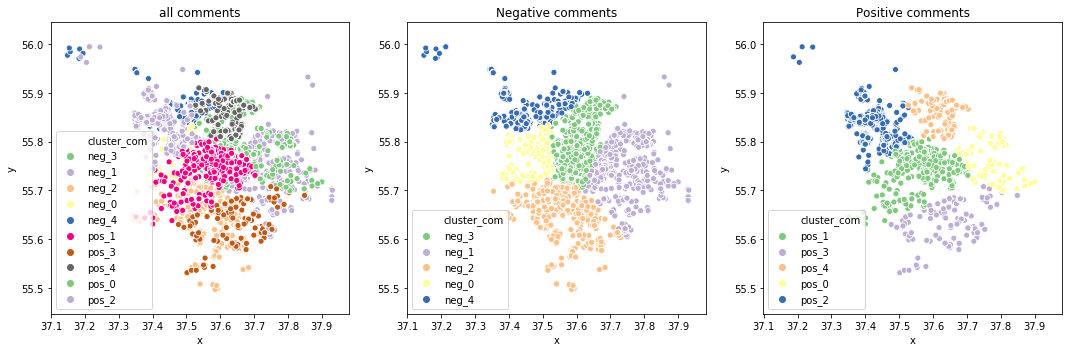

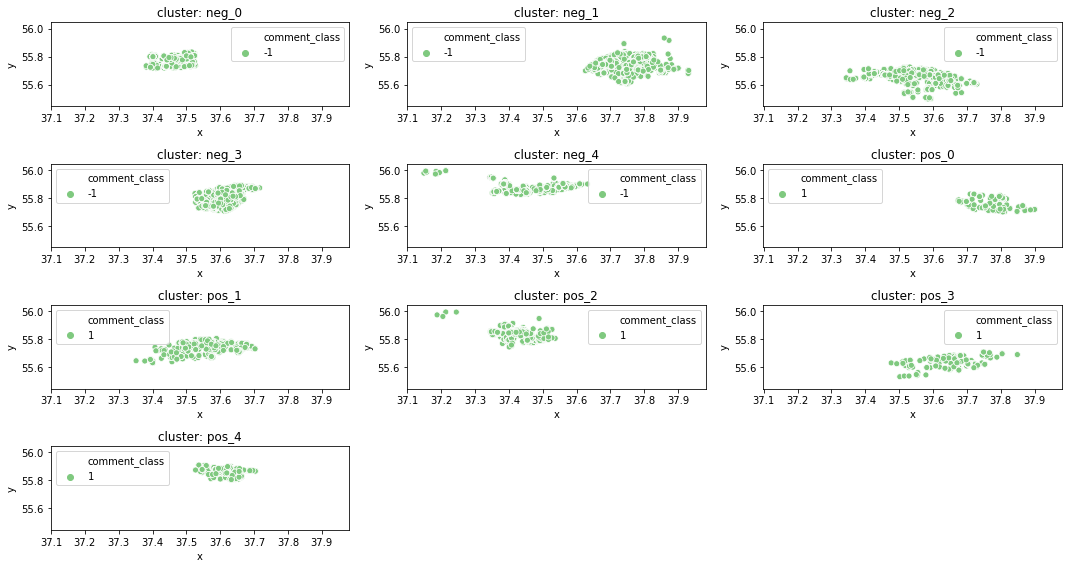

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.scatterplot(x='x', y='y', hue='cluster_com', data=geo_ds, palette='Accent', legend='full')
plt.title('all comments')
plt.xlim(xlim);plt.ylim(ylim)

plt.subplot(132)
sns.scatterplot(x='x', y='y', hue='cluster_com', data=geo_ds_neg, palette='Accent', legend='full')
plt.title("Negative comments")
plt.xlim(xlim);plt.ylim(ylim)

plt.subplot(133)
sns.scatterplot(x='x', y='y', hue='cluster_com', data=geo_ds_pos, palette='Accent', legend='full')
plt.title("Positive comments")
plt.xlim(xlim);plt.ylim(ylim)

plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
n_cluster = geo_ds['cluster_com'].nunique()
for idx,v in enumerate(geo_ds['cluster_com'].drop_duplicates().sort_values()):
    plt.subplot(n_cluster//3+1, 3, idx+1)
    sns.scatterplot(x='x', y='y', data=geo_ds[geo_ds['cluster_com']==v],
                    hue='comment_class', palette='Accent', legend='full')
    plt.title(f'cluster: {v}')
    plt.xlim(xlim);plt.ylim(ylim)
plt.tight_layout()

plt.show()

Кластеризации для положительных комментариев и для отрицательных получились немного разными, но есть ощущение, что изменения можно объяснить случайными погрешностями

In [18]:
from sklearn.metrics import silhouette_score

In [19]:
for m, cds in [('all comments',geo_ds), ('positive',geo_ds_pos), ('negative',geo_ds_neg)]:
    idxs = np.random.randint(0, len(cds), size=10000)
    cds = cds[['x_scal','y_scal']].iloc[idxs]
    cds['cluster'] = KMeans(5).fit_predict(cds)
    print(m,silhouette_score(cds.drop('cluster',1), cds['cluster']))

all comments 0.4964983930707519
positive 0.7408083045709832
negative 0.5323415854063048


Позитивные отзывы лучше кластеризуются. Это может быть связано с тем, что их очень мало, из-за чего их координаты сильнее разрежены. То есть все точки изначально находятся не так близко друг к другу, как для негативных отзывов

### 3) *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*

In [20]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(geo_ds[['x_scal','y_scal']])
    k_inertia.append(clf_kmeans.inertia_)

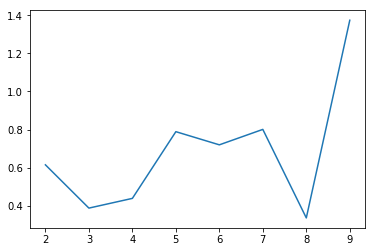

In [21]:
diff = np.diff(k_inertia)
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [22]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

8

Наилучшее количество кластеров - 3 или 8

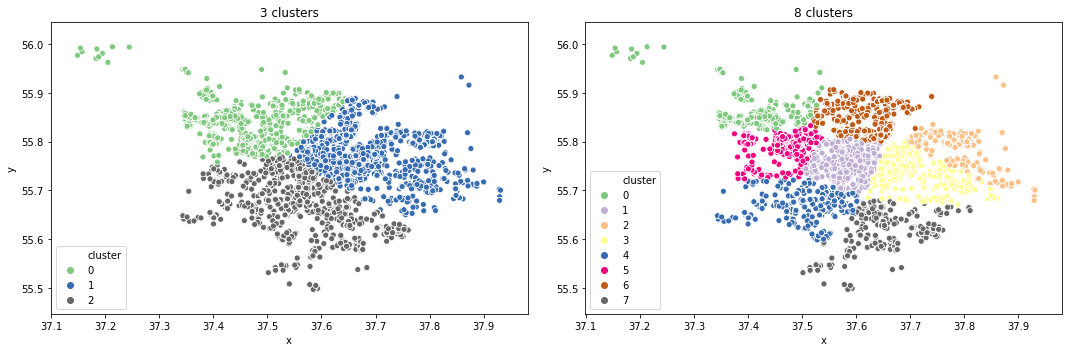

In [23]:
plt.figure(figsize=(15,5))

m = KMeans(n_clusters=3)
geo_ds['cluster'] = m.fit_predict(geo_ds[['x_scal','y_scal']])
plt.subplot(121)
sns.scatterplot(x='x', y='y', hue='cluster', data=geo_ds, palette='Accent', legend='full')
plt.xlim(xlim), plt.ylim(ylim)
plt.title('3 clusters')

m = KMeans(n_clusters=8)
geo_ds['cluster'] = m.fit_predict(geo_ds[['x_scal','y_scal']])
plt.subplot(122)
sns.scatterplot(x='x', y='y', hue='cluster', data=geo_ds, palette='Accent', legend='full')
plt.xlim(xlim), plt.ylim(ylim)
plt.title('8 clusters')

plt.tight_layout()
plt.show()

## Дополнительные задания

### 1) найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*

In [24]:
from sklearn.cluster import DBSCAN

По какой-то причине DBSCAN валит мой ноутбук, если подать ему на вход всю таблицу geo_ds

In [25]:
cds = geo_ds.copy()
idxs = np.random.randint(0, len(cds), size=100000)
cds = cds.iloc[idxs]

In [30]:
cds.shape[0]/geo_ds.shape[0]

0.9190669632189401

In [36]:
dbscan = DBSCAN(eps=0.2)
cds['cluster'] = dbscan.fit_predict(cds[['x_scal','y_scal']])

In [41]:
cds['outlier_flag'] = cds['cluster']==-1

In [44]:
cds['outlier_flag'].mean(),cds['outlier_flag'].value_counts()

(0.00021, False    99979
 True        21
 Name: outlier_flag, dtype: int64)

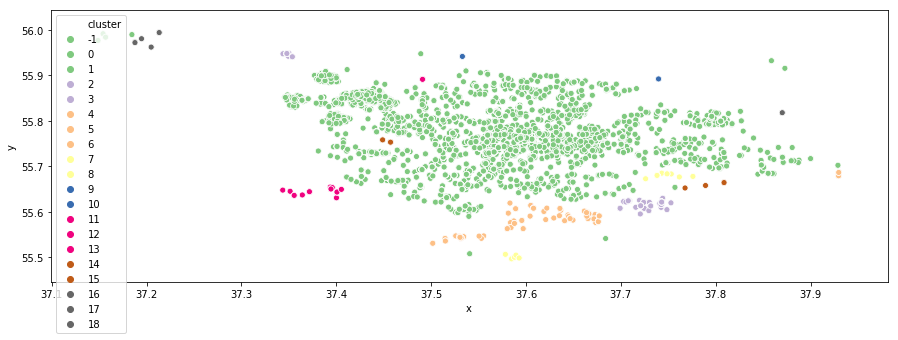

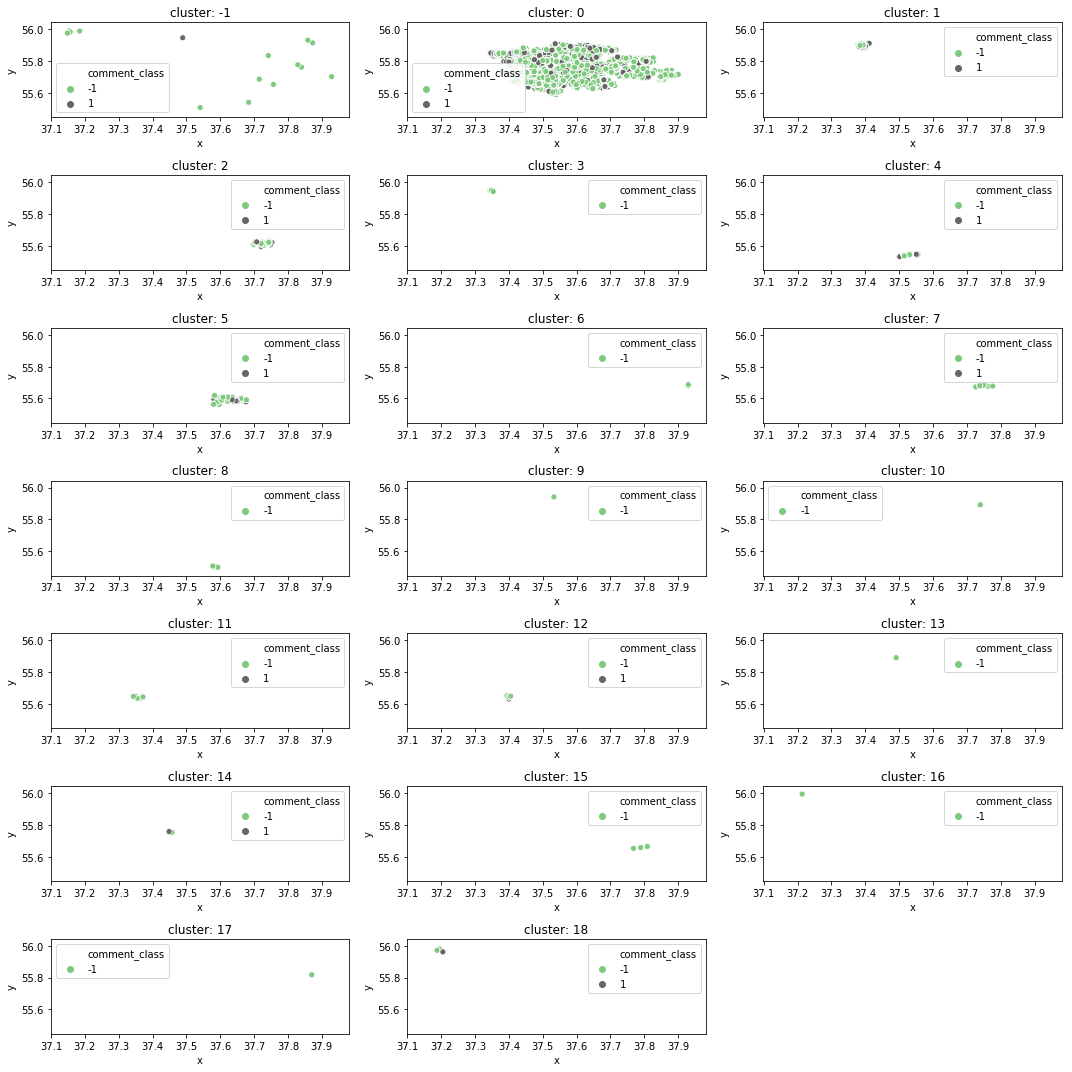

In [60]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='x', y='y', hue='cluster', data=cds, palette='Accent', legend='full')
plt.xlim(xlim);plt.ylim(ylim)
plt.show()

plt.figure(figsize=(15,15))
n_cluster = cds['cluster'].nunique()
for idx,v in enumerate(range(n_cluster)):
    v = v-1
    plt.subplot(n_cluster//3+1, 3, idx+1)
    sns.scatterplot(x='x', y='y', data=cds[cds['cluster']==v],
                    hue='comment_class', palette='Accent', legend='full')
    plt.title(f'cluster: {v}')
    plt.xlim(xlim);plt.ylim(ylim)
plt.tight_layout()
    
plt.show()

Почти все кластеры, кроме 0 очень малочисленны. В какой-то мере их тоже можно считать выбросами.

In [64]:
cds['cluster'].value_counts()/len(cds)*100

 0     97.174
 2      0.961
 1      0.647
 5      0.451
 3      0.256
 8      0.152
 7      0.073
 4      0.061
 6      0.050
 12     0.042
 9      0.039
 10     0.021
-1      0.021
 15     0.016
 11     0.009
 14     0.007
 18     0.005
 13     0.005
 16     0.005
 17     0.005
Name: cluster, dtype: float64

Кластеры 7,4,6 и т.д. имеют меньше 0.1% отзывов. Добавим их к кластеру -1

In [91]:
s = cds['cluster'].value_counts()
s = s/len(cds)*100
s = s[s<0.1]
s = s.index

In [93]:
cds['outlier_flag'] = cds['cluster'].isin(s)

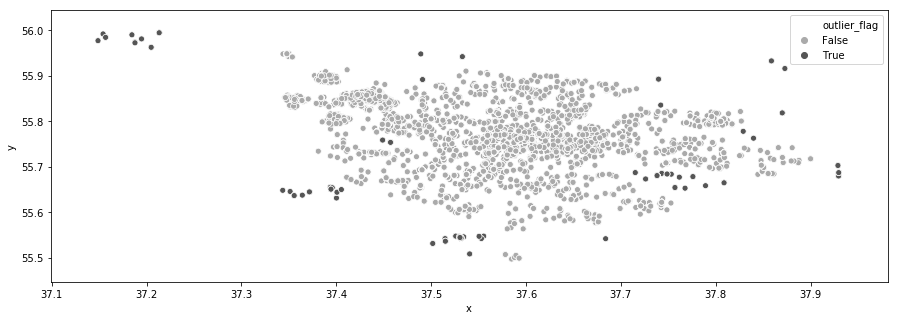

In [94]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='x',y='y', data=cds, hue='outlier_flag', palette='gray_r', legend='full')
plt.xlim(xlim); plt.ylim(ylim)
plt.show()

Райны, в которых мало комментариев находятся по периметру Москвы и в Зеленограде.

### 2) для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию